<a href="https://colab.research.google.com/github/MarcosVeniciu/Rede-Neural-Siamesa/blob/main/Arquitetura_NIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Referencias principais
## Artigo: https://arxiv.org/pdf/1503.03832.pdf
## Código: https://medium.com/@crimy/one-shot-learning-siamese-networks-and-triplet-loss-with-keras-2885ed022352
## Gerar Triplets: https://omoindrot.github.io/triplet-loss
## Keras triple loss exemplo: https://www.tensorflow.org/addons/tutorials/losses_triplet?hl=pt-br#semihard_online_learning
#
# Referências
## Função de TripletHardLoss: https://www.tensorflow.org/addons/api_docs/python/tfa/losses/TripletHardLoss
## Função de TripletSemiHardLoss: https://www.tensorflow.org/addons/api_docs/python/tfa/losses/TripletSemiHardLoss
## Triple loss keras:  https://keras.io/examples/vision/siamese_network/ 
## Keras fit e fit_generator: https://acervolima.com/keras-fit-e-keras-fit_generator/
## keras fit, fit_generator e train_on_batch: https://studymachinelearning-com.translate.goog/keras-fit-fit_generator-train_on_batch/?_x_tr_sl=en&_x_tr_tl=pt&_x_tr_hl=pt-BR&_x_tr_pto=sc
## Código usando o fit_generator: https://github.com/Ekeany/Siamese-Network-with-Triplet-Loss/blob/master/MachinePart1.ipynb
## explicação axis=-1: https://stackoverflow-com.translate.goog/questions/47435526/what-is-the-meaning-of-axis-1-in-keras-argmax?_x_tr_sl=en&_x_tr_tl=pt&_x_tr_hl=pt-BR&_x_tr_pto=sc
## explicação max pooling: https://www.quora.com/What-is-Max-Pooling-2D

In [1]:
!pip install -q -U tensorflow-addons

In [2]:
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import os

# Dataset

In [3]:
def _normalize_img(img, label):
    img = tf.cast(img, tf.float32)
    return (img, label)

train_ds, test_dataset = tfds.load(name="mnist", split=['train', 'test'], as_supervised=True)

# Build your input pipelines
train_ds = train_ds.shuffle(1024).batch(128)

train_ds = train_ds.map(_normalize_img)

test_dataset = test_dataset.batch(32)
test_dataset = test_dataset.map(_normalize_img)

# Modelo

In [4]:
# https://paperswithcode.com/paper/network-in-network (artigo da rede)
# https://github.com/minoring/nin-tf2/blob/master/model.py (Código de referência)

def define_nin(input_shape):
  """Define Network in Network model
  Returns:
    tf.keras.Model of NIN
  """
  input_tensor = keras.Input(shape=input_shape)
  scale_layer = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1 / 127.5, offset=-1)
  x = scale_layer(input_tensor)
  
  x = layers.Conv2D(192, 5, activation='relu')(x)
  x = layers.Conv2D(160, 1, activation='relu')(x)
  x = layers.Conv2D(96, 1, activation='relu')(x)
  x = layers.MaxPool2D(2, strides=2, padding='same')(x)
  x = layers.Dropout(0.5)(x)

  x = layers.Conv2D(192, 5, activation='relu')(x)
  x = layers.Conv2D(192, 1, activation='relu')(x)
  x = layers.Conv2D(192, 1, activation='relu')(x)
  x = layers.MaxPool2D(2, strides=2, padding='same')(x)
  x = layers.Dropout(0.5)(x)

  x = layers.Conv2D(192, 3, activation='relu')(x)
  x = layers.Conv2D(192, 1, activation='relu')(x)
  x = layers.Conv2D(10, 1, activation='relu')(x)
  x = layers.AveragePooling2D(pool_size=(2, 2))(x)
  x = layers.Flatten()(x)
  x = layers.Dense(10, kernel_regularizer= tf.keras.regularizers.L2(1e-3))(x)
  output_tensor = layers.Lambda(lambda x: tf.math.l2_normalize(x,axis=-1))(x)

  return tf.keras.Model(input_tensor, output_tensor, name = "Arquitetura_NIN")

# Treinamento

In [ ]:
# referencia dos hiperparametros: https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf
#                                 https://arxiv.org/pdf/1312.4400v3.pdf

In [5]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=60, monitor="loss", restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", mode = "min", patience = 10, factor=0.1, min_lr=0.000000000001, verbose = 0)
  ]

In [6]:
model = define_nin((28, 28, 1))
model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss=tfa.losses.TripletSemiHardLoss())

In [7]:
!nvidia-smi
historico = model.fit(train_ds, epochs=200, callbacks=my_callbacks)
model.save("embedding_model_nin.h5")

Thu Mar  2 15:25:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    30W /  70W |    347MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# wfdd

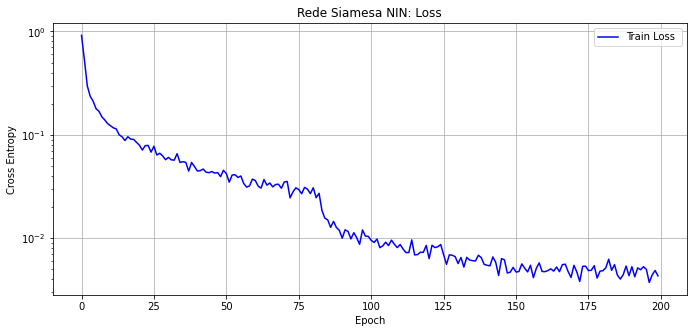

In [8]:
def grafico(historico, nome): 

  plt.subplots(figsize=(25, 5)) 
  # Grafico 1: Loss
  plt.subplot(1,2,1)
  plt.title( nome + ': Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Cross Entropy')
  plt.grid()
  plt.yscale("log")
  plt.plot(historico.history['loss'], label='Train Loss ', color = 'blue')
  plt.legend()

  nome_save = os.path.join("/content", nome + ".jpg")
  plt.savefig(nome_save, dpi=400,  transparent=False)
  plt.show()

grafico(historico, "Rede Siamesa NIN")

# Testes

## Funções

In [9]:
nome = ["zero", "um", "dois", "tres", "quatro", "cinco", "seis", "sete", "oito", "nove"]

def prepare_database(model):
  database = {}
  for categoria in range(10):# Busca pra cada uma das 10 categorias
    for img, label in test_dataset: # percorre os lotes do dataset
      for indice in range(len(label)): # percorre os elementos do lote do dataset
        if label[indice] == categoria: # se a categoria do elemento no indice for o mesma da categoria que estou buscando
          identity =  nome[categoria] 
          database[identity] = img_to_encoding(img[indice:indice+1], model)
          break
      if indice != (len(label)-1): break
  return database

In [10]:
def recognise_class(image, database, model):
    encoding = img_to_encoding(image, model)
    identity = None
    min_dist = 100
    for (name, db_enc) in database.items():
        
        dist = np.linalg.norm(db_enc - encoding)
        #print('distance for %s is %s' %(name, dist))
        if dist < min_dist:
            min_dist = dist
            identity = name
    
    if min_dist > 0.6:
        return "can't recognise."
    else:
        return str(identity)

def recognise_class_2(image, database, model):# A diferença dessa pra outra é que ela mostra a distancia
    encoding = img_to_encoding(image, model)
    identity = None
    min_dist = 100
    for (name, db_enc) in database.items():
        
        dist = np.linalg.norm(db_enc - encoding)
        print('distance for %s is %s' %(name, dist)) # seria muito ruim ficar mostrando isso para um dataset de 10.000 imagens
        if dist < min_dist:
            min_dist = dist
            identity = name
    
    if min_dist > 0.6:
        return "can't recognise."
    else:
        return str(identity)

In [11]:
def img_to_encoding(img, model):
  embedding = model.predict(img, verbose=0)
  return embedding

In [12]:
def metricas(saida):
  certo = 0
  errado = 0
  incerto = 0
  
  for resposta in saida:
    if resposta[1] == nome[resposta[0]]:
      certo += 1
    else:
      if resposta[1] == "can't recognise.":
        incerto += 1
      else:
        if resposta[1] != nome[resposta[0]]:
          errado += 1
  print()
  print("Total de imagem: {0}    Certas: {1}   Erradas: {2}   Incertas: {3}".format(len(saida), certo, errado, incerto))

## Testes

In [13]:
database = prepare_database(model)
saida = []

for img, label in tqdm (test_dataset, desc="Testando..."):
  for i in range(len(img)):
    classe = recognise_class(img[i:i+1], database, model)
    #print("id {2}:: Classe Real: {0} >> Classe Prevista: {1}".format(label[i], classe, i))
    saida.append([label[i], classe])

metricas(saida)

Testando...: 100%|██████████| 313/313 [12:22<00:00,  2.37s/it]



Total de imagem: 10000    Certas: 9945   Erradas: 33   Incertas: 22


In [ ]:
classe = recognise_class_2(img[0:1], database, model)
print()
print("Classe Real: {0} >> Classe Prevista: {1}".format(label[0], classe))